In [1]:
# import os
# os.chdir('basenji')

## basenji
## ├── data
## │   └── MDA_MB_231_LM2.entire-gene.is-exon.dataset.required-cols.pkl
## ├── model.py
## ├── modules.py
## └── train-basenji.ipynb

In [2]:
import torch
import numpy as np
import pandas as pd
import random

# from models import Basenji
# from modules import Trainer
import models
# import modules
import modules_old

%load_ext autoreload
%autoreload 2

In [3]:
torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random_seed = 2022
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

num_threads = 4
torch.set_num_threads(num_threads)

In [4]:
data_path = 'data/MDA_MB_231_LM2.entire-gene.is-exon.dataset.required-cols.pkl'
# data_path = 'data/MDA_MB_231_LM2.entire-gene.is-exon.dataset.required-cols.csv'

In [5]:
param_vals = { 
    "mode": "regression", # "classification",
    "optimizer" : "Adam", 
    "init_lr": 0.001, 
    "optimizer_momentum": 0.9, 
    "weight_decay": 1e-3, 
    "loss": "binomial", # "bce",
    "loss_reduction": "mean",
    "num_targets": 1,
    "seq_len": 2**15, # 128*128*8,
    "min_seq_len": 2**12,
    "max_seq_len": 2**15,
    "target_window": 1024*32,
    "batch_size": 32, # 8
    "train_frac": 0.8, # "cut": 0.8,
    "val_frac": 0.1,
    "shuffle_data": False,
    "n_thres": 5,
    "num_workers": 2, # 8,
    "num_epochs": 100,
    "save_results": True,
    "read_nrows": 10000
}

In [6]:
model = models.Basenji(debug=False, max_seq_len = param_vals['max_seq_len'])
# model = models.SplicingCodeWithDilation(max_seq_len = param_vals['max_seq_len'])
model.compile(device)

In [8]:
# trainer = modules.Trainer(param_vals, model, data_path)
trainer = modules_old.Trainer(param_vals, model, data_path)
# trainer.train(debug=False)

init dsets


### Measure Uncertainty using Dropout while Evaluation

In [9]:
trainer.load_model(trainer.model, 'data/model/Basenji_dl13_32768_epoch100.pt')

In [ ]:
trainer.model.train() ### to enable dropout maskmake_loadersal_loader, _ = trainer.make_loaders()
sample_size = 30
_, val_loader, _ = trainer.make_loaders()
val_df = pd.DataFrame()
for s in range(sample_size):
    print(s)
    epoch_df = pd.DataFrame()
    for batch in val_loader:
        x, rand_x, n, k_s, tr_id, gene_id = batch
        x, rand_x, n, k_s = x.to(trainer.device), rand_x.to(trainer.device), n.to(trainer.device), k_s.to(trainer.device)
        
        out = trainer.model(x)
        p = torch.sigmoid(out.detach()).clone().flatten().cpu().tolist()
        
        out_rand = trainer.model(rand_x)
        p_rand = torch.sigmoid(out_rand.detach()).clone().flatten().cpu().tolist()
        
        if s==0:
            y = (k_s / n).detach().clone().flatten().cpu().tolist()
            batch_df = pd.DataFrame(zip(y, p, p_rand), index=tr_id, columns=['y', f'p_{s}', f'rand_{s}'])
        else:
            batch_df = pd.DataFrame(zip(p, p_rand), index=tr_id, columns=[f'p_{s}', f'rand_{s}'])
        
        epoch_df = pd.concat([epoch_df, batch_df])
    if s==0:
        val_df = epoch_df
    else:
        val_df = val_df.join(epoch_df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [11]:
val_df.head()

,p_0,rand_0,p_1,rand_1,p_2,rand_2,p_3,rand_3,p_4,rand_4,...,p_25,rand_25,p_26,rand_26,p_27,rand_27,p_28,rand_28,p_29,rand_29
ENST00000395174.6,0.002791,0.014800,0.006117,0.049560,0.006362,0.013748,0.002366,0.077869,0.005516,0.067881,...,0.015023,0.085570,0.006309,0.019224,0.004927,0.029208,0.003788,0.026348,0.005207,0.055094
ENST00000417905.1,0.001370,0.004182,0.006315,0.004519,0.001861,0.015028,0.002578,0.009756,0.001827,0.008150,...,0.001048,0.005425,0.003151,0.005618,0.002455,0.006621,0.002047,0.004673,0.002359,0.019046
ENST00000441305.5,0.007805,0.012595,0.020546,0.013034,0.008178,0.116191,0.011957,0.033117,0.008531,0.022839,...,0.007702,0.039755,0.004774,0.016339,0.012464,0.071265,0.014936,0.033067,0.005918,0.017141
ENST00000404526.6,0.012875,0.005868,0.006790,0.003658,0.020484,0.009595,0.017022,0.009633,0.008848,0.015790,...,0.038033,0.038947,0.033852,0.009064,0.017073,0.019348,0.004772,0.021655,0.007407,0.017143
ENST00000438369.5,0.005863,0.013501,0.005229,0.008182,0.008091,0.044978,0.035161,0.052088,0.015654,0.030203,...,0.007131,0.041251,0.002630,0.010690,0.015940,0.045440,0.006583,0.032449,0.008657,0.007321


In [22]:
val_p = val_df.filter(like='p_')

In [ ]:
val_p['mean'] = val_p.mean(axis=1)
val_p['std'] = val_p.std(axis=1)

In [24]:
val_p['mean'].describe()

count    2603.000000
mean        0.168527
std         0.201355
min         0.000997
25%         0.016800
50%         0.066328
75%         0.272265
max         0.892871
Name: mean, dtype: float64

In [25]:
val_p['std'].describe()

count    2603.000000
mean        0.043669
std         0.038071
min         0.000478
25%         0.008207
50%         0.030381
75%         0.078026
max         0.153227
Name: std, dtype: float64

In [27]:
val_p.head()

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,p_22,p_23,p_24,p_25,p_26,p_27,p_28,p_29,mean,std
ENST00000395174.6,0.002791,0.006117,0.006362,0.002366,0.005516,0.005774,0.007658,0.012224,0.005537,0.001362,...,0.015686,0.002790,0.010834,0.015023,0.006309,0.004927,0.003788,0.005207,0.006815,0.004211
ENST00000417905.1,0.001370,0.006315,0.001861,0.002578,0.001827,0.003596,0.005638,0.001968,0.005707,0.002614,...,0.004219,0.002155,0.003126,0.001048,0.003151,0.002455,0.002047,0.002359,0.003307,0.001561
ENST00000441305.5,0.007805,0.020546,0.008178,0.011957,0.008531,0.019909,0.004919,0.006670,0.005019,0.005993,...,0.011689,0.009028,0.025613,0.007702,0.004774,0.012464,0.014936,0.005918,0.010520,0.005063
ENST00000404526.6,0.012875,0.006790,0.020484,0.017022,0.008848,0.014497,0.021427,0.033803,0.019275,0.009617,...,0.016718,0.010624,0.017420,0.038033,0.033852,0.017073,0.004772,0.007407,0.017357,0.008873
ENST00000438369.5,0.005863,0.005229,0.008091,0.035161,0.015654,0.006147,0.011393,0.013986,0.011034,0.020851,...,0.008682,0.021442,0.009434,0.007131,0.002630,0.015940,0.006583,0.008657,0.011398,0.006962


In [29]:
data = pd.read_pickle(data_path)

In [31]:
data.drop(columns=['seq', 'len', 'is_exon'], inplace=True)

In [34]:
data.set_index('tr_id', inplace=True)

In [35]:
data.rename({'xlr': 'k_s', 'total_reads': 'n'}, axis=1, inplace=True)

In [36]:
val_p = val_p[['mean', 'std']].join(data)

In [38]:
val_p['p_true'] = val_p.k_s / val_p.n

In [39]:
val_p.head()

,mean,std,gene_id,k_s,n,p_true
ENST00000395174.6,0.006815,0.004211,ENSG00000003756.17,1,94,0.010638
ENST00000417905.1,0.003307,0.001561,ENSG00000003756.17,0,94,0.000000
ENST00000441305.5,0.010520,0.005063,ENSG00000003756.17,0,94,0.000000
ENST00000404526.6,0.017357,0.008873,ENSG00000003756.17,0,94,0.000000
ENST00000438369.5,0.011398,0.006962,ENSG00000003756.17,0,94,0.000000


In [40]:
from scipy import stats
import matplotlib.pyplot as plt

In [41]:
stats.spearmanr(val_p[['mean', 'p_true']])

SpearmanrResult(correlation=0.5213488627366151, pvalue=2.1387494312257985e-181)

In [53]:
val_p['diff'] = np.abs(val_p['mean'] - val_p['p_true'])

In [56]:
val_p['diff'].describe()

count    2603.000000
mean        0.171974
std         0.214380
min         0.000333
25%         0.017135
50%         0.065739
75%         0.265810
max         0.997568
Name: diff, dtype: float64

In [58]:
stats.pearsonr(val_p['diff'], val_p['std'])

(0.6107291846117046, 5.801240249014677e-266)

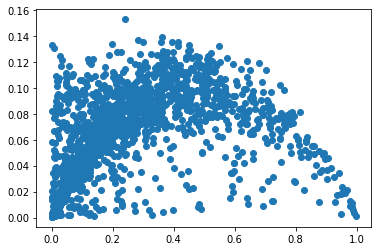

In [57]:
plt.scatter(val_p['diff'], val_p['std'])

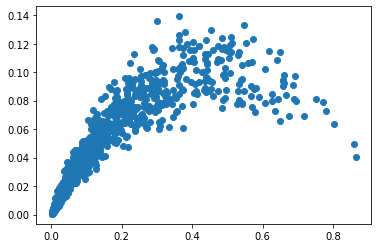

In [59]:
plt.scatter(val_p[val_p['p_true']==0]['diff'], val_p[val_p['p_true']==0]['std'])

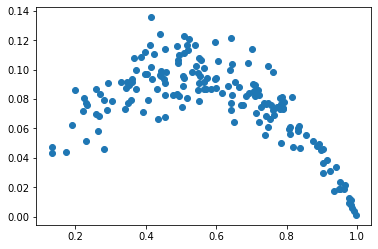

In [60]:
plt.scatter(val_p[val_p['p_true']==1]['diff'], val_p[val_p['p_true']==1]['std'])

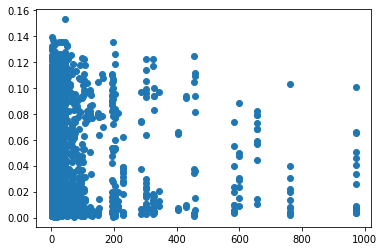

In [46]:
plt.scatter(val_p['n'], val_p['std'])

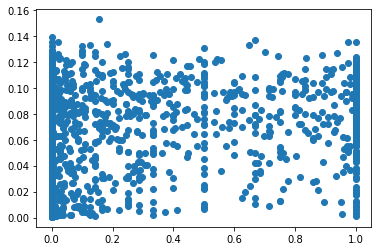

In [47]:
plt.scatter(val_p['p_true'], val_p['std'])

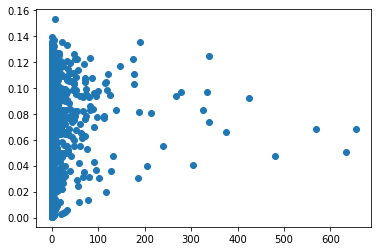

In [48]:
plt.scatter(val_p['k_s'], val_p['std'])

In [65]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from hyperopt import hp
from ray.tune.suggest.hyperopt import HyperOptSearch

In [ ]:
search_space = {
    'lr': tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
    'momentum': tune.uniform(0.1, 0.9)
    ## kernel sizes
    ## number of convolution layers
    ## dropout rates
    ## regularization coeffs
}

In [ ]:
trainer.config = search_space
tune.run(trainer.train,
         num_samples=20,
         scheduler=ASHAScheduler(metric='speaman_cor', mode='max'),
         config=trainer.config)